In [3]:
using CABLAB

In this study we investigate the redundancy the different variables in each pixel. Therefore we calculate a linear dimensionality reduction (PCA) and check how many dimensions are needed to explain 90% of the variance of a cube that contained originally 6 variables.  First we check out the variables from the cube and add some processors, because we want to do a global study

In [4]:
c     = Cube("/home/jovyan/work/datacube/cablab-datacube-0.2.3/low-res/")

CABLAB data cube at /home/jovyan/work/datacube/cablab-datacube-0.2.3/low-res/
Spatial resolution:  1440x720 at 0.25 degrees.
Temporal resolution: 2001-01-01T00:00:00 to 2012-01-01T00:00:00 at 8daily time steps
Variables:           aerosol_optical_thickness_1610 aerosol_optical_thickness_550 aerosol_optical_thickness_555 aerosol_optical_thickness_659 aerosol_optical_thickness_865 air_temperature_2m bare_soil_evaporation black_sky_albedo burnt_area c_emissions country_mask evaporation evaporative_stress fractional_snow_cover gross_primary_productivity interception_loss land_surface_temperature latent_energy net_ecosystem_exchange open_water_evaporation ozone potential_evaporation precipitation root_moisture sensible_heat snow_sublimation snow_water_equivalent soil_moisture surface_moisture terrestrial_ecosystem_respiration transpiration water_mask water_vapour white_sky_albedo 


In [5]:
vars  = ["gross_primary_productivity","latent_energy","root_moisture"
    ,"terrestrial_ecosystem_respiration","burnt_area","black_sky_albedo","net_ecosystem_exchange"];
cdata = getCubeData(c,variable=vars,region="Africa");

In [6]:
plotTS(cdata)

Interact.Options{:Dropdown,Int64}(Signal{Int64}(0, nactions=1),"Group",0,"None",Interact.OptionDict(DataStructures.OrderedDict("None"=>0,"Lon"=>1,"Lat"=>2,"Variable"=>4),Dict(0=>"None",4=>"Variable",2=>"Lat",1=>"Lon")),Any[],Any[],true,"horizontal")

Interact.Slider{Float64}(Signal{Float64}(16.75, nactions=1),"Lon",16.75,-17.0:0.25:50.75,"horizontal",true,".3f",true)

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=1),"Lat",0.0,-39.75:0.25:40.0,"horizontal",true,".3f",true)

Interact.Options{:Dropdown,Int64}(Signal{Int64}(5, nactions=1),"Variable",5,"burnt_area",Interact.OptionDict(DataStructures.OrderedDict("burnt_area"=>5,"latent_energy"=>2,"gross_primary_productivity"=>1,"terrestrial_ecosystem_respiration"=>4,"black_sky_albedo"=>6,"net_ecosystem_exchange"=>7,"root_moisture"=>3),Dict(7=>"net_ecosystem_exchange",4=>"terrestrial_ecosystem_respiration",2=>"latent_energy",3=>"root_moisture",5=>"burnt_area",6=>"black_sky_albedo",1=>"gross_primary_productivity")),Any[],Any[],true,"horizontal")

We perform some gapfilling, because the pca does not work with gaps

In [7]:
CABLAB.recalculate(true)
@loadOrGenerate cubeanom=>"DimRed_Anomalies" cube_filled=>"DimRed_Filled" begin
@time cube_filled     = mapCube(gapFillMSC,cdata);
#And we calculate the anomalies
@time cubeanom        = mapCube(removeMSC,cube_filled)
end

103.006323 seconds (61.14 M allocations: 4.138 GB, 1.95% gc time)
 61.262871 seconds (46.28 M allocations: 2.094 GB, 1.76% gc time)


true

In [8]:
@everywhere using MultivariateStats
@everywhere function sufficient_dimensions{T}(xout::AbstractArray{T}, xin::AbstractArray{T}, expl_var::Float64 = 0.95)
    if mapreduce(isnan,+,0,xin)>0
        return xout[1]=NaN
    end
    npoint, nvar = size(xin)
    means = mean(xin,1)
    stds  = std(xin,1)
    xin   = broadcast((y,m,s)->s>0.0 ? (y-m)/s : one(y),xin,means,stds)
    pca = fit(PCA, xin', pratio = 0.999, method = :svd)
    xout[1]  = findfirst(cumsum(principalvars(pca)) / tprincipalvar(pca) .> expl_var)
end 
registerDATFunction(sufficient_dimensions,(TimeAxis,VariableAxis),(),inmissing=(:nan,),outmissing=:nan,no_ocean=1);

In [9]:
#First we do the analysis on the original cube:
@loadOrGenerate qualitypca=>"DimRed_Quality_filled" begin
@time qualitypca=mapCube(sufficient_dimensions,cube_filled,0.90);
end

 40.722955 seconds (20.81 M allocations: 4.640 GB, 3.17% gc time)


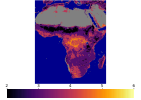

In [10]:
plotMAP(qualitypca,dmin=2,dmax=6)

And on the anomalies only:

In [11]:
@loadOrGenerate qualitypcaanom=>"DimRed_quality_anom" begin
qualitypcaanom=mapCube(sufficient_dimensions,cubeanom,0.90);
end

65536

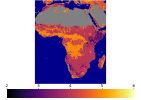

In [12]:
plotMAP(qualitypcaanom,dmin=2,dmax=6)